<a href="https://colab.research.google.com/github/AhnJG/AI-Project/blob/master/Colab/csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial provides an example of how to load CSV data from a file into a `tf.data.Dataset`.

The data used in this tutorial are taken from the Titanic passenger list. The model will predict the likelihood a passenger survived based on characteristics like age, gender, ticket class, and whether the person was traveling alone.

## Setup

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf


In [4]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("test.csv", TEST_DATA_URL)

16384/13049 [=====================================] - 0s 0us/step


In [0]:
# Make numpy values easier to read
np.set_printoptions(precision=3, suppress=True)

## Load data

To start, let's look at the top of the CSV file to see how it is formatted.

In [6]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


You can [load this using pandas](pandas.ipynb), and pass the NumPy arrays to TensorFlow. If you need to scale up to a large set of files, or need a loader that integrates with [TensorFlow and tf.data](../../guide/data.ipynb) then use the `tf.data.experimental.make_csv_dataset` function:

The only column you need to identify explicitly is the one with the value that the model is intended to predict. 

In [0]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

Now read the CSV data from the file and create a dataset. 

(For the full documentation, see `tf.data.experimental.make_csv_dataset`)


In [0]:
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

In [0]:
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

Each item in the dataset is a batch, represented as a tuple of (*many examples*, *many labels*). The data from the examples is organized in column-based tensors (rather than row-based tensors), each with as many elements as the batch size (5 in this case).

It might help to see this yourself.

In [10]:
show_batch(raw_train_data)

sex                 : [b'male' b'male' b'male' b'male' b'female']
age                 : [55.5 28.  47.  28.  36. ]
n_siblings_spouses  : [0 3 0 0 0]
parch               : [0 1 0 0 2]
fare                : [ 8.05  25.467 38.5   15.05  71.   ]
class               : [b'Third' b'Third' b'First' b'Second' b'First']
deck                : [b'unknown' b'unknown' b'E' b'unknown' b'B']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Cherbourg' b'Southampton']
alone               : [b'y' b'n' b'y' b'y' b'n']


As you can see, the columns in the CSV are named. The dataset constructor will pick these names up automatically. If the file you are working with does not contain the column names in the first line, pass them in a list of strings to  the `column_names` argument in the `make_csv_dataset` function.

In [0]:
CSV_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

temp_dataset = get_dataset(train_file_path, column_names=CSV_COLUMNS)

show_batch(temp_dataset)

This example is going to use all the available columns. If you need to omit some columns from the dataset, create a list of just the columns you plan to use, and pass it into the (optional) `select_columns` argument of the constructor.


In [0]:
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'class', 'deck', 'alone']

temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)

show_batch(temp_dataset)

## Data preprocessing

A CSV file can contain a variety of data types. Typically you want to convert from those mixed types to a fixed length vector before feeding the data into your model.

TensorFlow has a built-in system for describing common input conversions: `tf.feature_column`, see [this tutorial](../keras/feature_columns) for details.


You can preprocess your data using any tool you like (like [nltk](https://www.nltk.org/) or [sklearn](https://scikit-learn.org/stable/)), and just pass the processed output to TensorFlow. 


The primary advantage of doing the preprocessing inside your model is that when you export the model it includes the preprocessing. This way you can pass the raw data directly to your model.

### Continuous data

If your data is already in an appropriate numeric format, you can pack the data into a vector before passing it off to the model:

In [0]:
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]
temp_dataset = get_dataset(train_file_path, 
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)

show_batch(temp_dataset)

In [0]:
example_batch, labels_batch = next(iter(temp_dataset)) 

Here's a simple function that will pack together all the columns:

In [0]:
def pack(features, label):
  return tf.stack(list(features.values()), axis=-1), label

Apply this to each element of the dataset:

In [0]:
packed_dataset = temp_dataset.map(pack)

for features, labels in packed_dataset.take(1):
  print(features.numpy())
  print()
  print(labels.numpy())

If you have mixed datatypes you may want to separate out these simple-numeric fields. The `tf.feature_column` api can handle them, but this incurs some overhead and should be avoided unless really necessary. Switch back to the mixed dataset:

In [0]:
show_batch(raw_train_data)

In [0]:
example_batch, labels_batch = next(iter(temp_dataset)) 

So define a more general preprocessor that selects a list of numeric features and packs them into a single column:

In [0]:
class PackNumericFeatures(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels

In [0]:
NUMERIC_FEATURES = ['age','n_siblings_spouses','parch', 'fare']

packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

packed_test_data = raw_test_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

In [0]:
show_batch(packed_train_data)

In [0]:
example_batch, labels_batch = next(iter(packed_train_data)) 

#### Data Normalization

Continuous data should always be normalized.

In [0]:
import pandas as pd
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc

In [0]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [0]:
def normalize_numeric_data(data, mean, std):
  # Center the data
  return (data-mean)/std


Now create a numeric column. The `tf.feature_columns.numeric_column` API accepts a `normalizer_fn` argument, which will be run on each batch.

Bind the `MEAN` and `STD` to the normalizer fn using [`functools.partial`](https://docs.python.org/3/library/functools.html#functools.partial).

In [0]:
# See what you just created.
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
numeric_column

When you train the model, include this feature column to select and center this block of numeric data:

In [0]:
example_batch['numeric']

In [0]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

The mean based normalization used here requires knowing the means of each column ahead of time.

### Categorical data

Some of the columns in the CSV data are categorical columns. That is, the content should be one of a limited set of options.

Use the `tf.feature_column` API to create a collection with a `tf.feature_column.indicator_column` for each categorical column.



In [0]:
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}


In [0]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [0]:
# See what you just created.
categorical_columns

In [0]:
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

This will be become part of a data processing input later when you build the model.

### Combined preprocessing layer

Add the two feature column collections and pass them to a `tf.keras.layers.DenseFeatures` to create an input layer that will extract and preprocess both input types:

In [0]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)

In [0]:
print(preprocessing_layer(example_batch).numpy()[0])

## Build the model

Build a `tf.keras.Sequential`, starting with the `preprocessing_layer`.

In [0]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

## Train, evaluate, and predict

Now the model can be instantiated and trained.

In [0]:
train_data = packed_train_data.shuffle(500)
test_data = packed_test_data

In [0]:
model.fit(train_data, epochs=20)

Once the model is trained, you can check its accuracy on the `test_data` set.

In [0]:
test_loss, test_accuracy = model.evaluate(test_data)

print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

Use `tf.keras.Model.predict` to infer labels on a batch or a dataset of batches.

In [0]:
predictions = model.predict(test_data)

# Show some results
for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
  print("Predicted survival: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("SURVIVED" if bool(survived) else "DIED"))



---
---
---

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [2]:
from __future__ import absolute_import, division, unicode_literals, print_function
import functools

import numpy as np
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [3]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

16384/13049 [=====================================] - 0s 0us/step


In [0]:
# make numpy values easier to read
np.set_printoptions(precision=3, suppress=True)

In [4]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [0]:
LABEL_COLUMN = 'survived'
LABELS = [0,]

In [0]:
def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=5,
        label_name=LABEL_COLUMN,
        na_value="?",
        num_epochs=1,
        ignore_errors=True,
        **kwargs)
    return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

In [11]:
print(raw_train_data)

<PrefetchDataset shapes: (OrderedDict([(sex, (None,)), (age, (None,)), (n_siblings_spouses, (None,)), (parch, (None,)), (fare, (None,)), (class, (None,)), (deck, (None,)), (embark_town, (None,)), (alone, (None,))]), (None,)), types: (OrderedDict([(sex, tf.string), (age, tf.float32), (n_siblings_spouses, tf.int32), (parch, tf.int32), (fare, tf.float32), (class, tf.string), (deck, tf.string), (embark_town, tf.string), (alone, tf.string)]), tf.int32)>


<PrefetchDataset shapes: (OrderedDict([(sex, (None,)), (age, (None,)), (n_siblings_spouses, (None,)), (parch, (None,)), (fare, (None,)), (class, (None,)), (deck, (None,)), (embark_town, (None,)), (alone, (None,))]), (None,)), types: (OrderedDict([(sex, tf.string), (age, tf.float32), (n_siblings_spouses, tf.int32), (parch, tf.int32), (fare, tf.float32), (class, tf.string), (deck, tf.string), (embark_town, tf.string), (alone, tf.string)]), tf.int32)>

In [0]:
def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key, value.numpy()))

In [14]:
show_batch(raw_train_data)

sex                 : [b'male' b'female' b'male' b'male' b'male']
age                 : [26. 30. 28.  4. 37.]
n_siblings_spouses  : [0 0 0 4 2]
parch               : [0 0 0 2 0]
fare                : [  7.896 106.425   7.896  31.275   7.925]
class               : [b'Third' b'First' b'Third' b'Third' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Cherbourg' b'Southampton' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'y' b'n' b'n']


In [15]:
CSV_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

temp_dataset = get_dataset(train_file_path, column_names=CSV_COLUMNS)

show_batch(temp_dataset)

sex                 : [b'female' b'male' b'male' b'male' b'male']
age                 : [14. 28. 32. 22. 34.]
n_siblings_spouses  : [1 1 0 0 0]
parch               : [0 0 0 0 0]
fare                : [30.071 19.967 10.5    7.229  6.496]
class               : [b'Second' b'Third' b'Second' b'Third' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Cherbourg' b'Southampton' b'Southampton' b'Cherbourg' b'Southampton']
alone               : [b'n' b'n' b'y' b'y' b'y']


In [16]:
# csv에서 데이터를 가져오는데 원하는 컬럼을 지정해서 가져올 수 있다
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'class', 'deck', 'alone']

temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)

show_batch(temp_dataset)

age                 : [24. 48. 44. 28. 25.]
n_siblings_spouses  : [0 1 1 0 0]
class               : [b'Third' b'First' b'Second' b'Third' b'Third']
deck                : [b'G' b'A' b'unknown' b'unknown' b'unknown']
alone               : [b'n' b'n' b'n' b'n' b'y']


In [17]:
# data format을 지정할 수 있다
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]
temp_dataset = get_dataset(train_file_path,
                           select_columns=SELECT_COLUMNS,
                           column_defaults=DEFAULTS)
show_batch(temp_dataset)

age                 : [16.  19.  40.5 26.  24. ]
n_siblings_spouses  : [0. 1. 0. 2. 0.]
parch               : [0. 0. 2. 0. 0.]
fare                : [ 8.05   7.854 14.5    8.663  7.142]


In [0]:
example_batch, labels_batch = next(iter(temp_dataset))

In [21]:
labels_batch

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 1], dtype=int32)>

In [0]:
# this function will pack together all the columns
def pack(features, label):
    return tf.stack(list(features.values()), axis=-1), label

In [23]:
packed_dataset = temp_dataset.map(pack)

for features, labels in packed_dataset.take(1):
    print(features.numpy())
    print()
    print(labels.numpy())

[[ 17.      0.      0.      7.125]
 [ 28.      0.      0.      7.229]
 [ 64.      1.      4.    263.   ]
 [ 45.      0.      0.      6.975]
 [ 28.      1.      1.     15.246]]

[0 1 0 0 1]


In [24]:
print(packed_dataset)

<MapDataset shapes: ((None, 4), (None,)), types: (tf.float32, tf.int32)>


In [25]:
show_batch(raw_train_data)

sex                 : [b'male' b'male' b'male' b'male' b'male']
age                 : [28. 25. 20. 28. 25.]
n_siblings_spouses  : [0 0 0 0 0]
parch               : [0 0 0 0 0]
fare                : [ 8.05  13.     7.229  8.05   7.05 ]
class               : [b'Third' b'Second' b'Third' b'Third' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Cherbourg' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'y' b'y' b'y']


In [0]:
example_batch, labels_batch = next(iter(temp_dataset))

In [0]:
class PackNumericFeatures(object):
    def __init__(self, names):
        self.names = names
    
    def __call__(self, features, labels):
        numeric_features = [features.pop(name) for name in self.names]
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        numeric_features = tf.stack(numeric_features, axis=-1)
        features['numeric'] = numeric_features

        return features, labels

In [0]:
NUMERIC_FEATURES = ['age', 'n_siblings_spouses', 'parch', 'fare']

packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES)
)

packed_test_data = raw_test_data.map(
    PackNumericFeatures(NUMERIC_FEATURES)
)

In [29]:
show_batch(packed_train_data)

sex                 : [b'male' b'female' b'male' b'female' b'male']
class               : [b'Third' b'First' b'Third' b'First' b'Third']
deck                : [b'unknown' b'B' b'unknown' b'B' b'unknown']
embark_town         : [b'Southampton' b'Cherbourg' b'Queenstown' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'y' b'n' b'y']
numeric             : [[ 28.      0.      0.      8.05 ]
 [ 58.      0.      0.    146.521]
 [ 28.      0.      0.      7.829]
 [ 17.      1.      0.     57.   ]
 [ 28.      0.      0.      7.05 ]]


In [0]:
example_batch, labels_batch = next(iter(packed_train_data))

In [31]:
import pandas as pd
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [0]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [36]:
print(MEAN)
print(STD)

[29.631  0.545  0.38  34.385]
[12.512  1.151  0.793 54.598]


In [0]:
def normalize_numeric_data(data, mean, std):
    # Center the data
    return (data-mean)/std

In [39]:
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
numeric_column

NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x7f2a60fe4bf8>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598])))

In [45]:
example_batch['numeric']

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 23.   ,   0.   ,   0.   ,  10.5  ],
       [ 20.   ,   0.   ,   0.   ,   9.846],
       [ 27.   ,   0.   ,   2.   , 211.5  ],
       [ 22.   ,   0.   ,   0.   ,   9.   ],
       [ 28.   ,   0.   ,   1.   ,  55.   ]], dtype=float32)>

In [46]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

array([[-0.53 , -0.474, -0.479, -0.437],
       [-0.77 , -0.474, -0.479, -0.449],
       [-0.21 , -0.474,  2.043,  3.244],
       [-0.61 , -0.474, -0.479, -0.465],
       [-0.13 , -0.474,  0.782,  0.378]], dtype=float32)

In [0]:
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [50]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
    print(feature, vocab)

    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))

sex ['male', 'female']
class ['First', 'Second', 'Third']
deck ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
embark_town ['Cherbourg', 'Southhampton', 'Queenstown']
alone ['y', 'n']


In [51]:
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [53]:
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [0]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)

In [57]:
print(preprocessing_layer(example_batch).numpy())

[[ 1.     0.     0.     1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.    -0.53  -0.474
  -0.479 -0.437  1.     0.   ]
 [ 1.     0.     0.     0.     1.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.    -0.77  -0.474
  -0.479 -0.449  1.     0.   ]
 [ 0.     1.     1.     0.     0.     0.     0.     1.     0.     0.
   0.     0.     0.     0.     0.     1.     0.     0.    -0.21  -0.474
   2.043  3.244  1.     0.   ]
 [ 1.     0.     0.     0.     1.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.    -0.61  -0.474
  -0.479 -0.465  1.     0.   ]
 [ 0.     1.     1.     0.     0.     0.     0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.     0.     0.    -0.13  -0.474
   0.782  0.378  0.     1.   ]]


In [56]:
example_batch

OrderedDict([('sex',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'female'], dtype=object)>),
             ('class',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Second', b'Third', b'First', b'Third', b'First'], dtype=object)>),
             ('deck',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'C', b'unknown', b'E'], dtype=object)>),
             ('embark_town', <tf.Tensor: shape=(5,), dtype=string, numpy=
              array([b'Southampton', b'Southampton', b'Cherbourg', b'Southampton',
                     b'Southampton'], dtype=object)>),
             ('alone',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'y', b'n', b'y', b'n'], dtype=object)>),
             ('numeric', <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
              array([[ 23.   ,   0.   ,   0.   ,  10.5  ],
                     [ 20.   ,   0.   ,   0.   ,   9.846],


In [0]:
model = tf.keras.Sequential([
    preprocessing_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [0]:
train_data = packed_train_data.shuffle(500)
test_data = packed_test_data

In [63]:
model_history = model.fit(train_data, epochs=20)

Epoch 1/20
126/126 [==============================] - 1s 6ms/step - loss: 0.3050 - accuracy: 0.8756
Epoch 2/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.8676
Epoch 3/20
126/126 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8676
Epoch 4/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2975 - accuracy: 0.8740
Epoch 5/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2912 - accuracy: 0.8820
Epoch 6/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2968 - accuracy: 0.8820
Epoch 7/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2906 - accuracy: 0.8836
Epoch 8/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.8772
Epoch 9/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2824 - accuracy: 0.8836
Epoch 10/20
126/126 [==============================] - 0s 3ms/step - loss: 0.2797 - accuracy: 0.8836

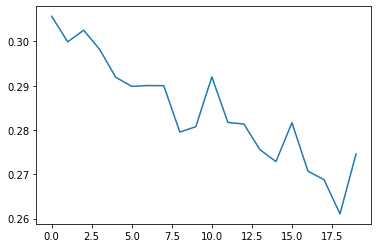

In [74]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'])

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_3 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  3200      
_________________________________________________________________
dense_7 (Dense)              multiple                  16512     
_________________________________________________________________
dense_8 (Dense)              multiple                  129       
Total params: 19,841
Trainable params: 19,841
Non-trainable params: 0
_________________________________________________________________


In [76]:
test_loss, test_accuracy = model.evaluate(test_data)

print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

     53/Unknown - 0s 9ms/step - loss: 0.5007 - accuracy: 0.8220

Test Loss 0.5007370582799304, Test Accuracy 0.8219696879386902


In [77]:
predictions = model.predict(test_data)

for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
    print("Predicted survival: {:2%}".format(prediction[0]),
          " | Actual outcome: ", 
          ("SURVIVED" if bool(survived) else "DIED"))

Predicted survival: 78.385383%  | Actual outcome:  SURVIVED
Predicted survival: 11.011033%  | Actual outcome:  DIED
Predicted survival: 53.968948%  | Actual outcome:  SURVIVED
Predicted survival: 7.577569%  | Actual outcome:  DIED
Predicted survival: 46.212319%  | Actual outcome:  DIED
